- Initial money: 10,000 USD
- for each week, use (6w & 3w) slope to decide if we are in bear market for EACH ETF

Bear = (6w < 0) & (3w not > 0)

| (BEAR_PREDICTION, CASH, AVG_COST, QUANTITY) | SP500 | BTC  | VIX  |
|---------------------------------------------|-------|------|------|
| Tickers                                     | VOO   | BITO | VIXM |
| 2022/3/1, Week 0                            |       |      |      |
| 2022/3/8, Week 1                            |       |      |      |
|                                             |       |      |      |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ib_insync import *

util.startLoop()
ib = IB()
ib.connect('127.0.0.1', 7497, clientId=0)

<IB connected to 127.0.0.1:7497 clientId=0>

In [2]:
def get_position(c):
    ib.qualifyContracts(c)
    for p in ib.positions():
        if p.contract == c:
            return p
    return None


def buy_with_money_constraint(c, cash):

    ib.reqMktData(c, '', False, False)
    t = ib.ticker(c)
    ib.sleep(2)

    initial_cash = cash

    # Repeat buy at ask price while we can at least buy 1 ETF
    while cash > t.ask:

        order = LimitOrder('BUY', int(min(cash / t.ask, t.askSize)), t.ask)
        trade = ib.placeOrder(c, order)
        print(
            f'Cash: {cash} Buying(LIMIT) {c.symbol} at ${trade.order.lmtPrice} for {trade.order.totalQuantity} units'
        )
        while not trade.isDone():
            ib.waitOnUpdate()
        cash -= trade.order.lmtPrice * trade.order.totalQuantity
    return cash


def sell_all(c):
    if get_position(c):
        order = MarketOrder('SELL', get_position(c).position)
        trade = ib.placeOrder(c, order)
        print(f'Selling(MARKET) {trade.order.totalQuantity} {c.symbol}')
        while not trade.isDone():
            ib.waitOnUpdate()
    return ib.positions()

Error 201, reqId 178: Order rejected - reason:No Trading Permission, Customer Ineligible; Ineligibility reasons: ,<html>Restricted: Must request Complex or Leveraged Exchange-Traded Product permissions for trading. To close existing position, please use the Close button; see <a href="https://www.interactivebrokers.com/lib/cstools/faq/#/content/faq%3A%2F%2FpageId%3D84620875">FAQ 84620875</a> </html>
Canceled order: Trade(contract=Stock(conId=521525019, symbol='BITO', exchange='SMART', primaryExchange='ARCA', currency='USD', localSymbol='BITO', tradingClass='BITO'), order=LimitOrder(orderId=178, permId=1559348815, action='BUY', totalQuantity=366.0, lmtPrice=27.32, auxPrice=0.0), orderStatus=OrderStatus(orderId=178, status='Cancelled', filled=0.0, remaining=366.0, avgFillPrice=0.0, permId=1559348815, parentId=0, lastFillPrice=0.0, clientId=0, whyHeld='', mktCapPrice=0.0), fills=[], log=[TradeLogEntry(time=datetime.datetime(2022, 3, 1, 17, 29, 50, 559514, tzinfo=datetime.timezone.utc), sta

Cash: 10000 Buying(LIMIT) BITO at $27.32 for 366 units


KeyboardInterrupt: 

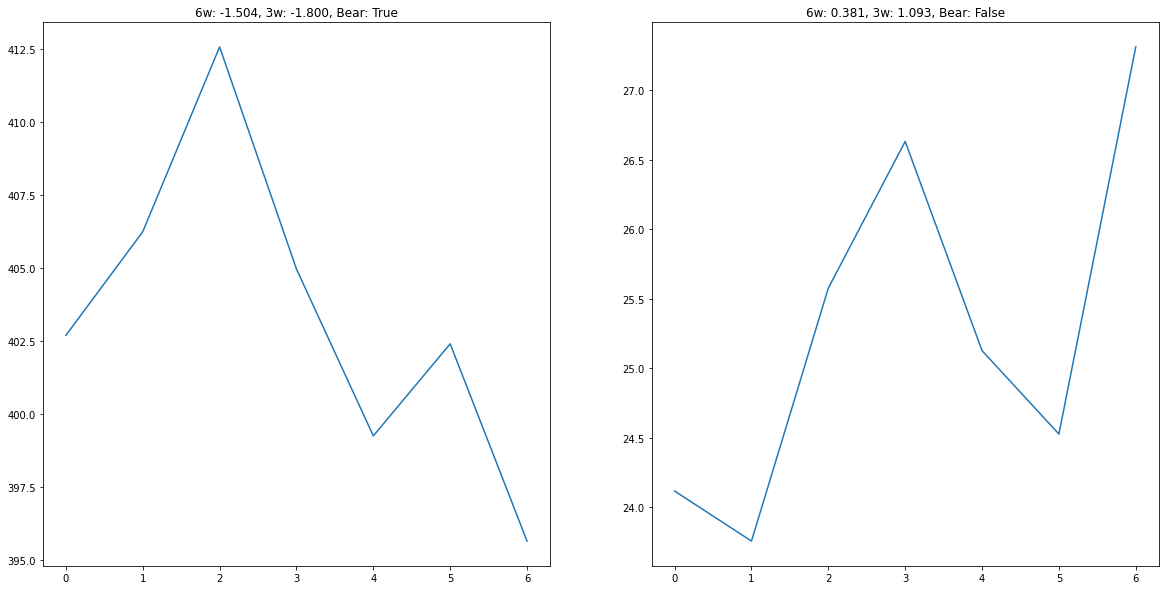

Peer closed connection.


In [5]:
portfolio = {'VOO': 10000, 'BITO': 10000}
contracts = [Stock(_, 'SMART', 'USD') for _ in portfolio]
ib.qualifyContracts(*contracts)

plt.figure(figsize=(10 * len(portfolio), 10))
for i, c in enumerate(contracts):
    bars = ib.reqHistoricalData(c,
                                endDateTime='',
                                durationStr='6 W',
                                barSizeSetting='1 W',
                                whatToShow='MIDPOINT',
                                useRTH=True)

    # convert to pandas dataframe:
    df = util.df(bars)

    X = sm.add_constant(df.index)
    Y = df['close']

    slope_6 = sm.OLS(Y, X).fit().params['x1']

    X = sm.add_constant(df[4:].index)
    Y = df[4:]['close']

    slope_3 = sm.OLS(Y, X).fit().params['x1']

    bear = (slope_6 < 0) and not (slope_3 > 0)

    plt.subplot(1, len(portfolio), i + 1)
    plt.plot(df['close'])
    plt.title(f'6w: {slope_6:.3f}, 3w: {slope_3:.3f}, Bear: {bear}')

    if not bear:
        buy_with_money_constraint(c, portfolio[c.symbol])
    else:
        pass
        sell_all(c)

In [4]:
contracts = [Stock(_, 'SMART', 'USD') for _ in ('VOO', 'BITO', 'VIXM')]
ib.qualifyContracts(*contracts)

df = pd.DataFrame(index=[c.symbol for c in contracts],
                  columns=['bidSize', 'bid', 'ask', 'askSize'])

for c in contracts:
    ib.reqMktData(c, '', False, False)
    t = ib.ticker(c)
    ib.sleep(2)
    df.loc[t.contract.symbol] = (t.bidSize, t.bid, t.ask, t.askSize)
df

,bidSize,bid,ask,askSize
VOO,100.0,395.82,395.85,500.0
BITO,8100.0,27.32,27.33,600.0
VIXM,300.0,33.31,33.36,800.0
